# Анализ отзывов в Steam. 

## Часть 0: обзор датафрейма и очистка данных.

**ВНИМАНИЕ! Код в данном файле во время исполнения считывает локальные данные.**

Цель: провести исследовательский анализ отзывов

In [25]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [26]:
df_filename = './data/apex-legends-steam-reviews.csv'
df = pd.read_csv(df_filename)

## 1 Анализ распределений

Посмотрим на различные распределения. Начнем с распределения числа оставляемых отзывов по датам.

In [27]:
df['Date'] = pd.to_datetime(df['Date'])
df['Text'] = df['Text'].apply(str)

In [28]:
df[df['Recommended'] == True].shape, df[df['Recommended'] == False].shape

((9346, 5), (5344, 5))

In [29]:
data = df[['Text', 'Date']].groupby('Date', as_index=False).count().sort_values('Date').reset_index()

/tmp/ipykernel_115859/994605298.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60)


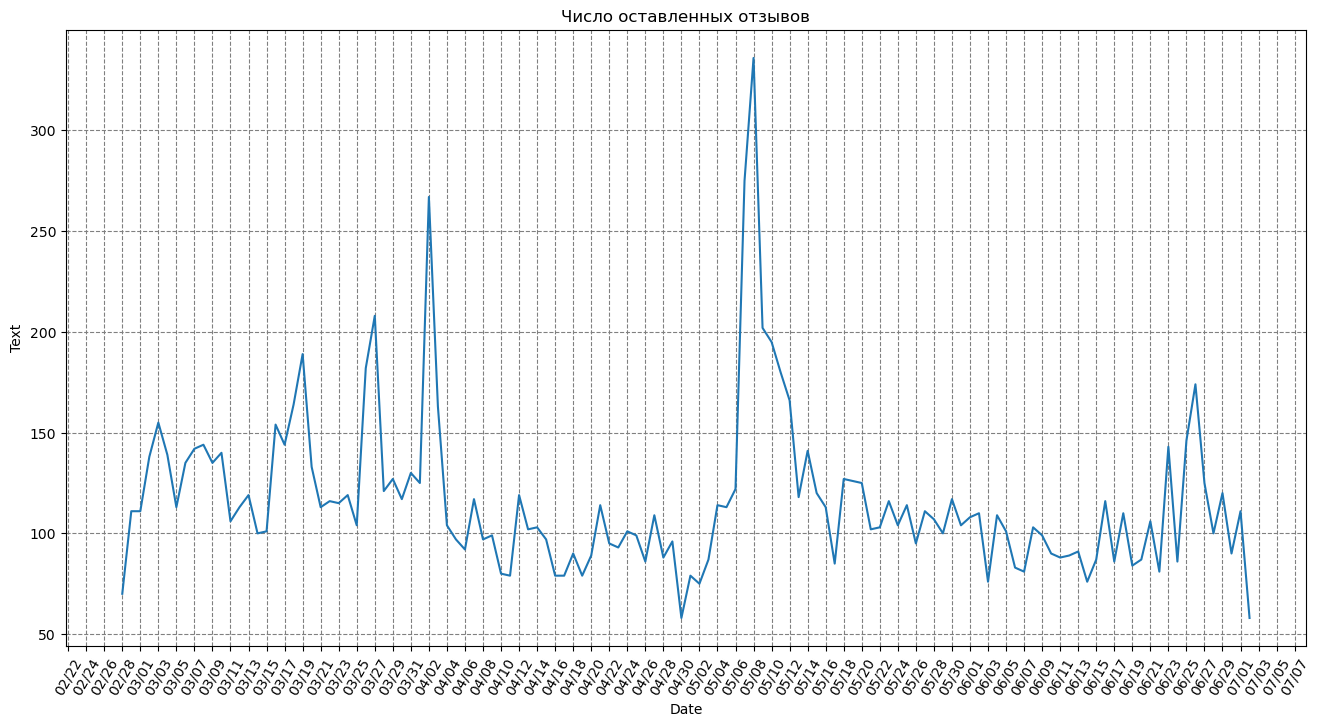

In [30]:
fig, ax = plt.subplots(figsize=(16, 8))

sns.lineplot(data,
             x='Date', y='Text')

plt.grid(visible=True, color='grey', linestyle='--')

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

plt.title('Число оставленных отзывов')

plt.show()

Наблюдаются пики активности в следующие даты: 19 марта, 2 апреля, 8 мая и 26 июня. Перед поиском причин посмотрим на график, на котором отметим показатели негативных и позитивных отзывов.

In [31]:
data = df[['Date', 'Text', 'Recommended']].groupby(by=['Date', 'Recommended']).count().sort_values('Date').reset_index()

In [32]:
data.head()

,Date,Recommended,Text
0,2024-02-28,False,22
1,2024-02-28,True,48
2,2024-02-29,False,32
3,2024-02-29,True,79
4,2024-03-01,False,22


/tmp/ipykernel_115859/3657958609.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60)


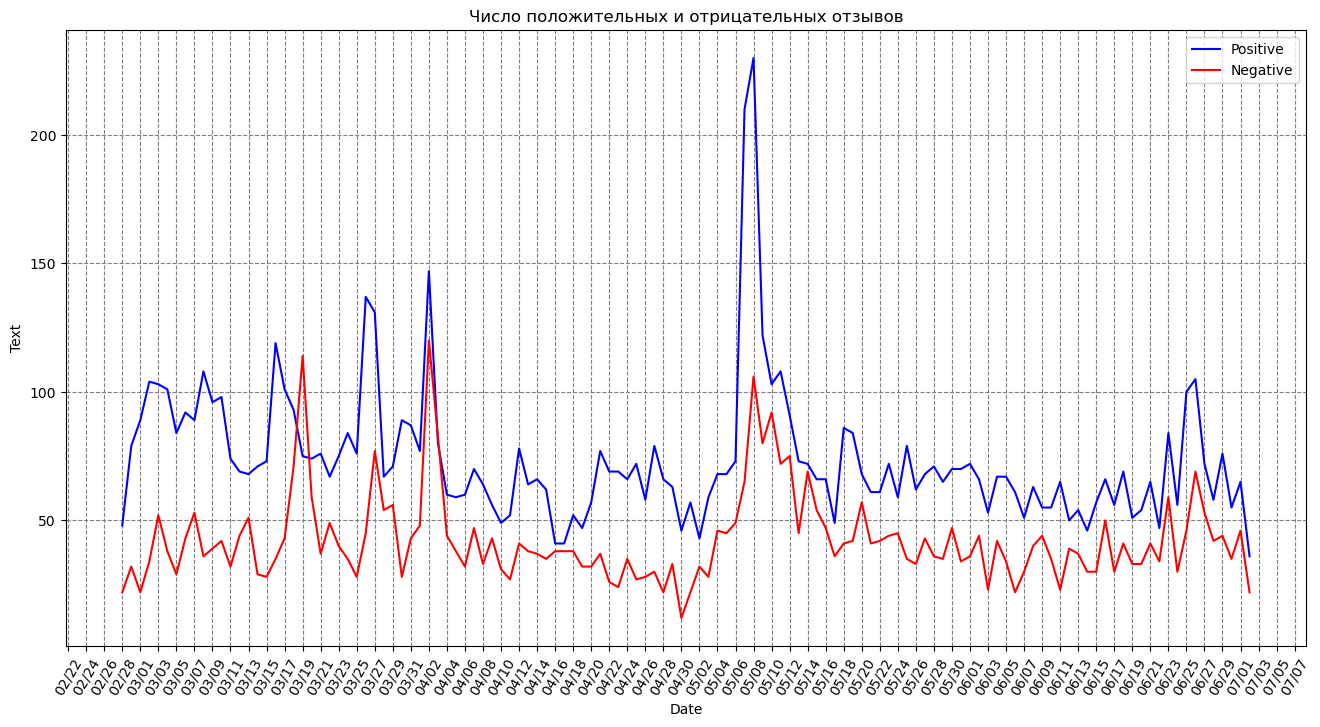

In [33]:
fig, ax = plt.subplots(figsize=(16, 8))

sns.lineplot(data[data['Recommended'] == True],
             x='Date', y='Text',
             color='blue', label='Positive')
sns.lineplot(data[data['Recommended'] == False],
             x='Date', y='Text',
             color='red', label='Negative')


plt.grid(True, color='grey', linestyle='--')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

plt.title('Число положительных и отрицательных отзывов')
plt.show()

В целом, положительных отзывов почти всегда больше, чем отрицательных. Исключение -- 19 марта. По новостям -- в этот день на ALGS произошел скандал с использованием читов. 16 марта, 26 марта, 2 апреля рост числа отзывов обусловлен новыми ивентами и сезонами.
8 мая число отзывов резко увеличилось до уровня выше 350 в день. В это время проходил финал первого сплита ALGS в формате LAN турнира в Лос-Анджелесе.

На следующем графике покажем положительные и отрицательные отзывы в процентном соотношении.

In [34]:
data = df[['Date', 'Text', 'Recommended']].groupby(by=['Date', 'Recommended'], as_index=False).count().sort_values('Date').reset_index().rename(columns={'Text': 'Count'})
data_positive = data[data['Recommended'] == True].reset_index()
data_negative = data[data['Recommended'] == False].reset_index()


In [35]:
df[['Date', 'Text']].groupby('Date').count()

,Text
Date,
2024-02-28,70
2024-02-29,111
2024-03-01,111
2024-03-02,138
2024-03-03,155
...,...
2024-06-28,100
2024-06-29,120
2024-06-30,90


In [36]:
for d in [data_positive, data_negative]:
    d['Rate'] = d['Count'] / df[['Date', 'Text']].groupby('Date').count().sort_values('Date').reset_index().rename(columns={'Text': 'Count'})['Count']

    

/tmp/ipykernel_115859/1237324033.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60)


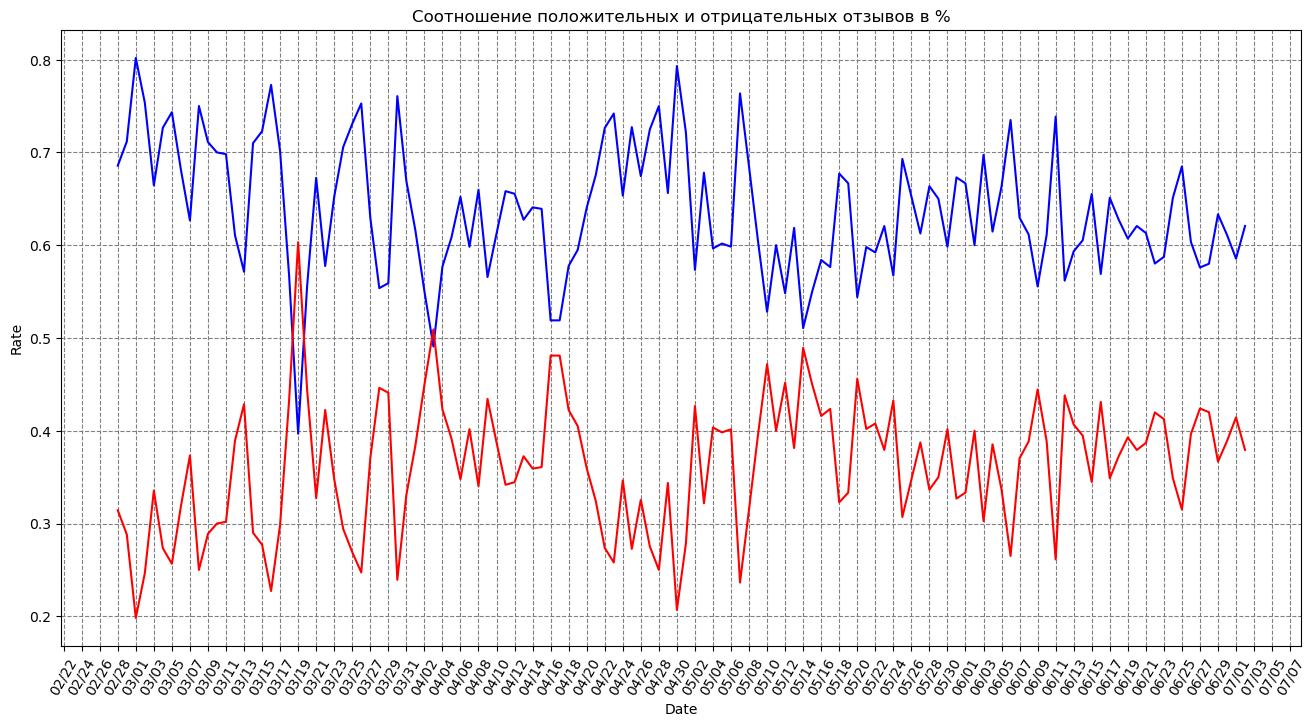

In [37]:
fig, ax = plt.subplots(figsize=(16, 8))

sns.lineplot(data_positive,
             x='Date', y='Rate',
             color='blue')
sns.lineplot(data_negative,
             x='Date', y='Rate',
             color='red')

plt.grid(True, color='grey', linestyle='--')

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

plt.title('Соотношение положительных и отрицательных отзывов в %')
plt.show()

За исключением дней со скандальными происшествиями у видеоигры наблюдается высокий уровень положительных отзывов (60-70%).

Можем также посмотреть на распределение часов в игре у рецензентов. Также построим подобные распределения как для положительных так и для отрицательных отзывов.

In [38]:
data_positive = df[df['Recommended'] == True]
data_negative = df[df['Recommended'] == False]

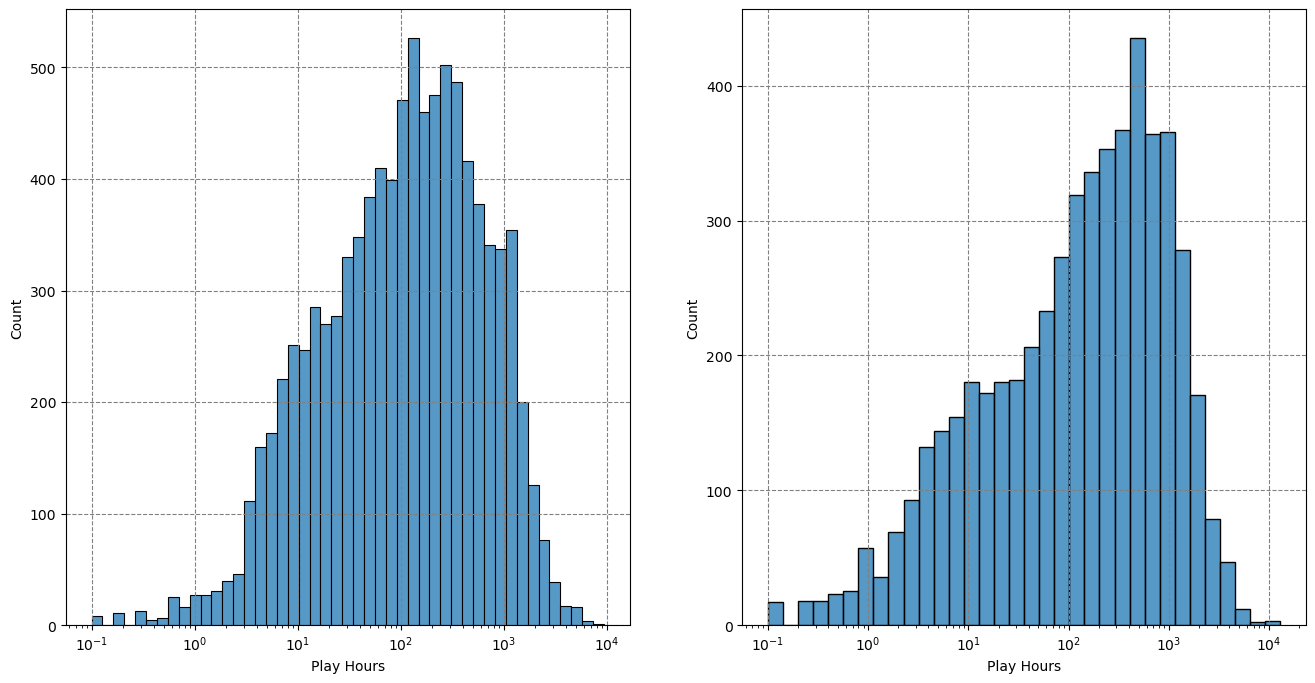

In [39]:
from scipy.stats import mode

fig = plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.histplot(data_positive,
             x='Play Hours', log_scale=True)

plt.grid(True, linestyle='--', color='grey')

plt.subplot(1, 2, 2)
sns.histplot(data_negative,
             x='Play Hours', log_scale=True)

plt.grid(True, linestyle='--', color='grey')

plt.show()

Распределение часов среди негативных отзывов оказалось чуть более суженным и мода этих отзывов смещена в сторону больших значений. Это говорит о том, что более опытные игроки в среднем чаще оставляют негативные отзывы, чем это делают игроки с небольшим опытом.

Проследим основные слова, которые фигурируют в двух категориях отзывов.

In [40]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from collections import Counter

import re

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anatolii/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
stop_words = set(stopwords.words('english'))
custom_stop_words = ['game', 'apex', 'legends', 'legend', 'steam', 'play']

In [42]:
def preprocess_text(text: str) -> str:
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ',text)
    text = text.lower().strip()
    text = ' '.join([word for word in text.split() if word not in stop_words and word not in custom_stop_words])
    return text

In [43]:
data_positive = df[df['Recommended'] == True]['Text'].apply(preprocess_text)
data_negative = df[df['Recommended'] == False]['Text'].apply(preprocess_text)

In [44]:
words_positive_counter = Counter(' '.join(data_positive).split())
words_negative_counter = Counter(' '.join(data_negative).split())

In [45]:
from wordcloud import WordCloud

In [46]:
words_positive = ' '.join(data_positive)
words_negative = ' '.join(data_negative)

In [47]:
wordcloud_positive = WordCloud(width=800, height=800, background_color='white').generate(words_positive)
wordcloud_negative = WordCloud(width=800, height=800, background_color='white').generate(words_negative)

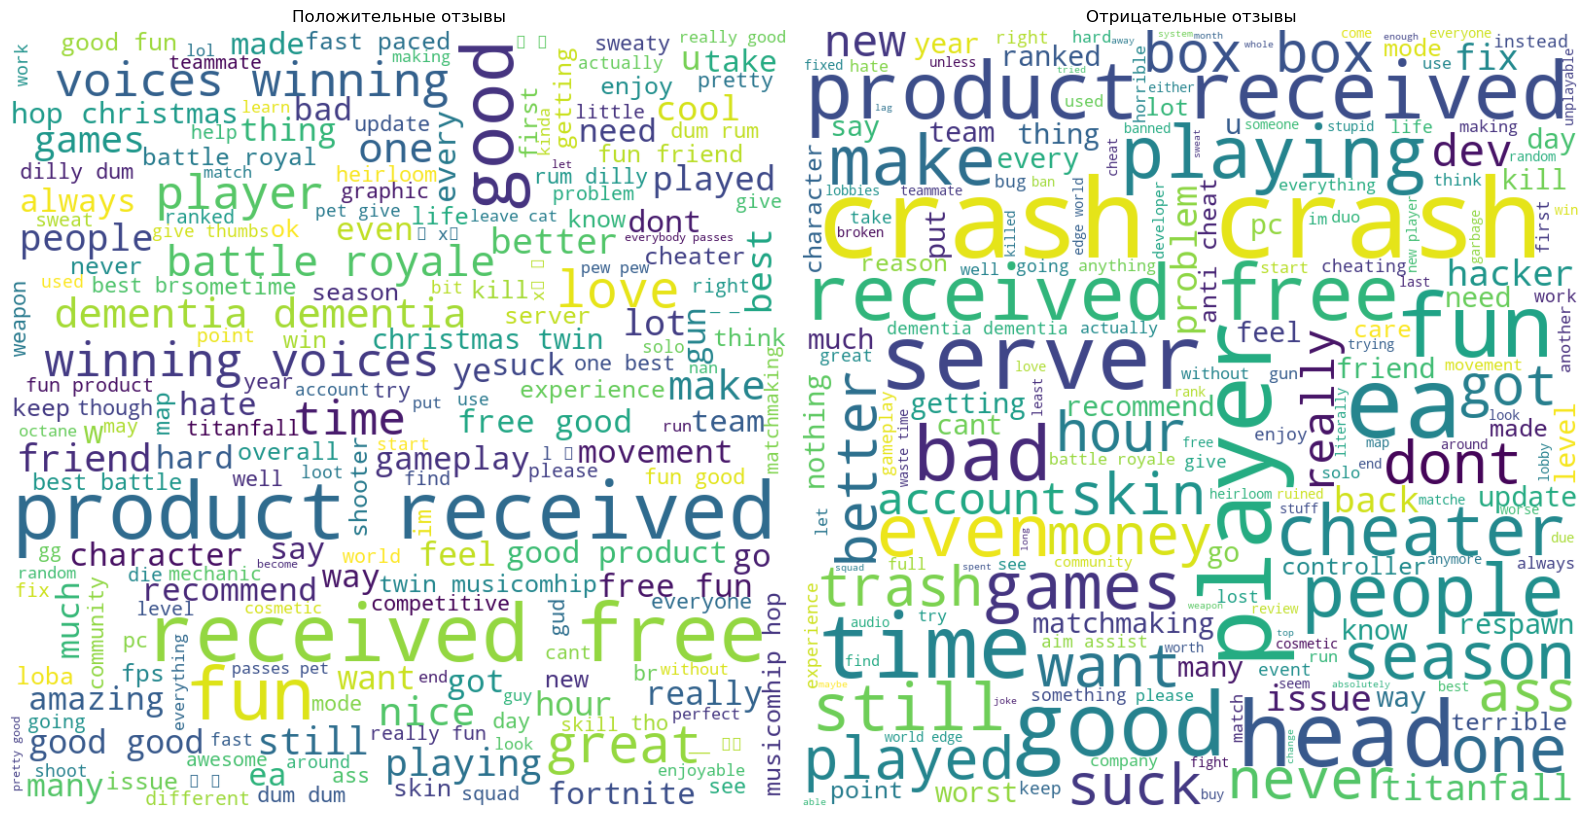

In [48]:
plt.figure(figsize=(16, 16))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Положительные отзывы')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Отрицательные отзывы')

plt.tight_layout()
plt.show()

Среди положительных слов видны различные аспекты: игроки отмечают free-to-play модель игры, эмоции от побед, сложность, механики (movement) и нередко упоминают имена легенд (возмонжо своих любимых).
Главное недовольство вызывают: краши и технические проблемы, проблемы с сетевым кодом и работой серверов, желание заработать на скинах или их плохое качество, читеры.